# Titanic Dataset

## Library Imports

In [270]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning and Feature Engineering

In [271]:
df_titanic_raw = pd.read_csv('titanic/train.csv')

In [272]:
df_titanic_raw = df_titanic_raw[(df_titanic_raw['Age'].notna())  & (df_titanic_raw['Fare'].notna()) & (df_titanic_raw['Embarked'].notna())]
df_titanic_raw = df_titanic_raw.drop(['PassengerId', 'Name', 'Ticket'],axis=1)

In [273]:
df_titanic_raw['Sex'].replace(['male', 'female'], [1, 0], inplace=True)
df_titanic_raw['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)
df_titanic_raw = df_titanic_raw.reset_index(drop=True)
df_titanic_raw

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,2
1,1,1,0,38.0,1,0,71.2833,C85,0
2,1,3,0,26.0,0,0,7.9250,NaN,2
3,1,1,0,35.0,1,0,53.1000,C123,2
4,0,3,1,35.0,0,0,8.0500,NaN,2
...,...,...,...,...,...,...,...,...,...
707,0,3,0,39.0,0,5,29.1250,NaN,1
708,0,2,1,27.0,0,0,13.0000,NaN,2
709,1,1,0,19.0,0,0,30.0000,B42,2
710,1,1,1,26.0,0,0,30.0000,C148,0


In [274]:
df_titanic_raw['Deck'] = df_titanic_raw['Cabin'].map(lambda x: x[0] if x is not np.nan else 'U')
df_titanic_raw['Deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)
df_titanic_raw['Age_Group'] = df_titanic_raw['Age'].map(lambda x: 0 if x < 18 else 1)
df_titanic_engineered = df_titanic_raw.drop(['Cabin'], axis=1)
df_titanic_engineered['Family_Size']=df_titanic_raw['SibSp'] + df_titanic_raw['Parch']
df_titanic_engineered['Fare_Per_Person']=df_titanic_engineered['Fare'] / (df_titanic_engineered['Family_Size'] + 1)
df_titanic = df_titanic_engineered

survived_labels = ['No', 'Yes']
age_labels = ['Child', 'Adult']
class_labels = ['1st', '2nd', '3rd']
embarked_labels = ['Cherbourg', 'Queenstown', 'Southampton']
sex_labels = ['Female', 'Male']
deck_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']

df_titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Age_Group,Family_Size,Fare_Per_Person
0,0,3,1,22.0,1,0,7.2500,2,8,1,1,3.625000
1,1,1,0,38.0,1,0,71.2833,0,2,1,1,35.641650
2,1,3,0,26.0,0,0,7.9250,2,8,1,0,7.925000
3,1,1,0,35.0,1,0,53.1000,2,2,1,1,26.550000
4,0,3,1,35.0,0,0,8.0500,2,8,1,0,8.050000
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,3,0,39.0,0,5,29.1250,1,8,1,5,4.854167
708,0,2,1,27.0,0,0,13.0000,2,8,1,0,13.000000
709,1,1,0,19.0,0,0,30.0000,2,1,1,0,30.000000
710,1,1,1,26.0,0,0,30.0000,0,2,1,0,30.000000


<AxesSubplot: title={'center': 'Titanic Attributes Correlation Heatmap'}>

<Figure size 1000x500 with 0 Axes>

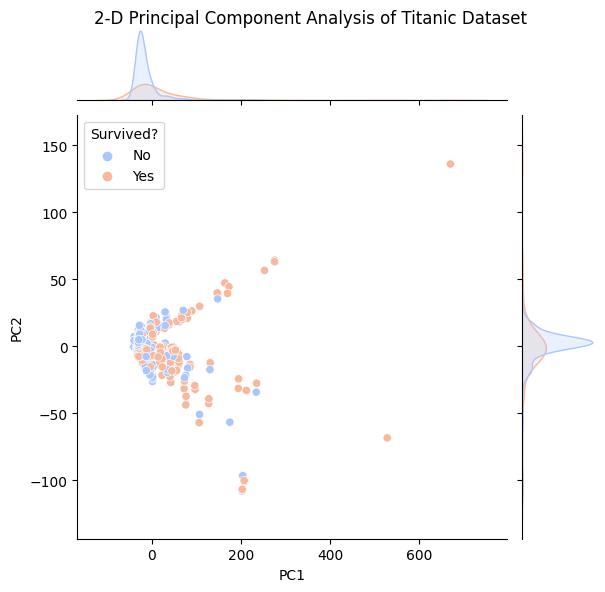

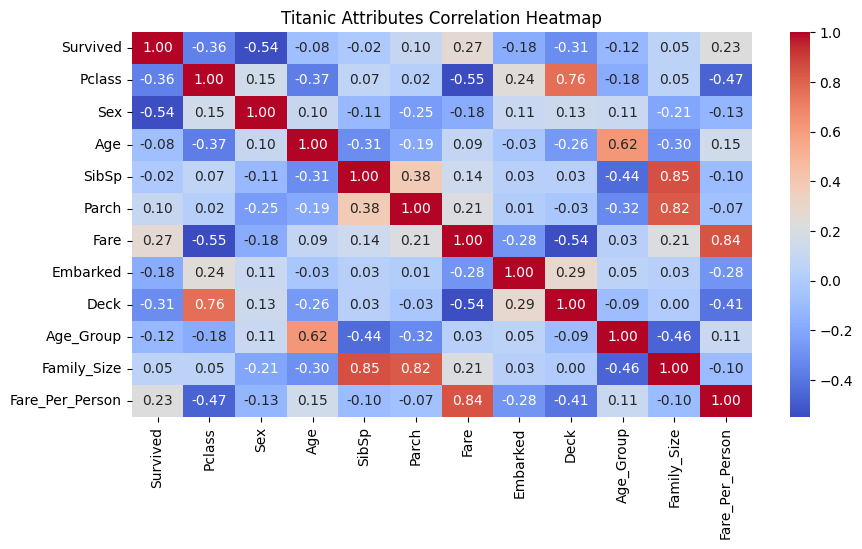

In [275]:
plt.figure(figsize=(10, 5))
pca = PCA(n_components=2)
pca.fit(df_titanic)
pca_df = pd.DataFrame(pca.transform(df_titanic), columns=['PC1', 'PC2'])
pca_df['Survived'] = df_titanic['Survived']

jg = sns.jointplot(data=pca_df, x="PC1", y="PC2", hue="Survived", palette='coolwarm')
jg.fig.subplots_adjust(top=0.95)
jg.fig.suptitle('2-D Principal Component Analysis of Titanic Dataset')
ax = plt.gca()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=survived_labels, title='Survived?')


fig, ax0 = plt.subplots(figsize=(10, 5))

ax0.set_title('Titanic Attributes Correlation Heatmap')
corr = df_titanic.corr()
sns.heatmap(ax=ax0, data=round(corr, 2), annot=True, cmap="coolwarm", fmt='.2f')

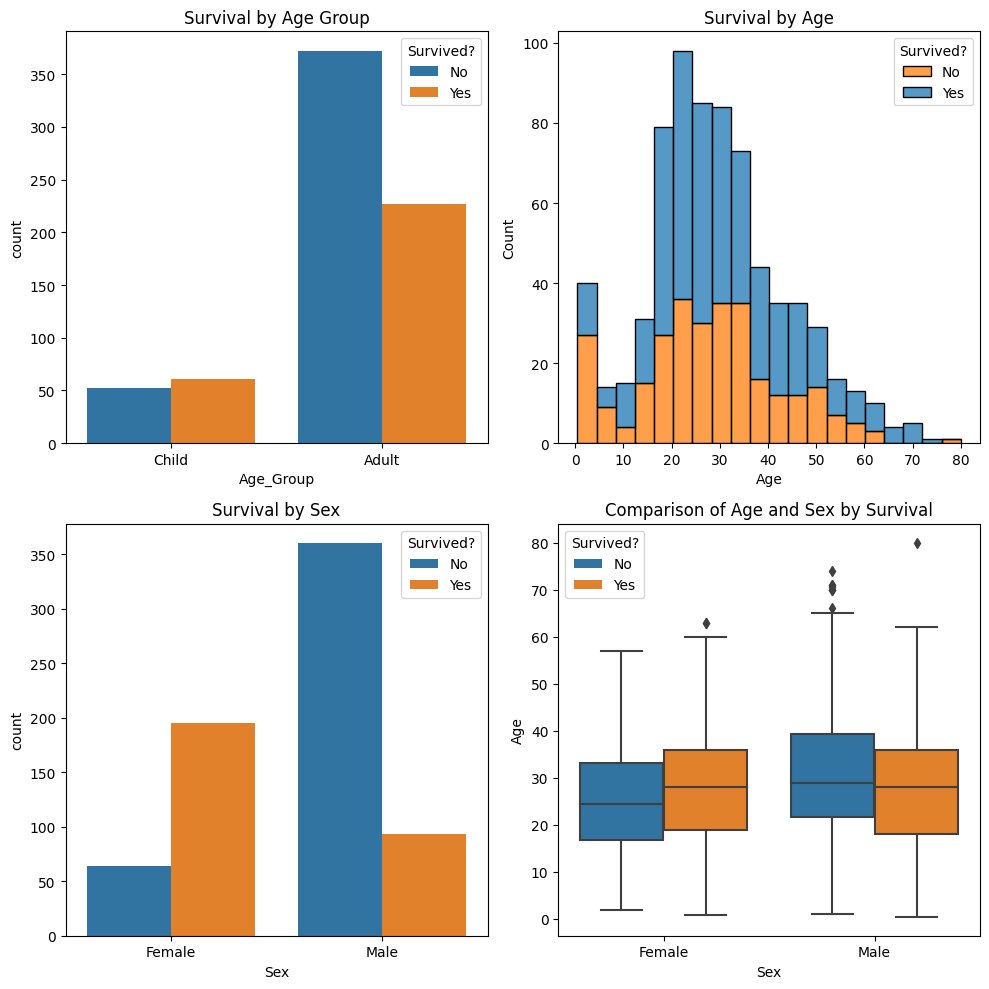

In [276]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax0.set_title('Survival by Age Group')
sns.countplot(ax=ax0, data=df_titanic, x="Age_Group", hue="Survived")
ax0.set_xticklabels(age_labels)
ax0.legend(survived_labels, title='Survived?')

ax1.set_title('Survival by Age')
sns.histplot(ax=ax1, data=df_titanic, x="Age", hue="Survived", multiple="stack")
ax1.legend(survived_labels, title='Survived?')

ax2.set_title('Survival by Sex')
sns.countplot(ax=ax2, data=df_titanic, x="Sex", hue="Survived")
ax2.set_xticklabels(sex_labels)
ax2.legend(survived_labels, title='Survived?')

ax3.set_title('Comparison of Age and Sex by Survival')
sns.boxplot(ax=ax3, data=df_titanic, x="Sex", y="Age", hue="Survived")
ax3.set_xticklabels(sex_labels)
handles, _ = ax2.get_legend_handles_labels()
ax3.legend(handles=handles, labels=survived_labels, title='Survived?')


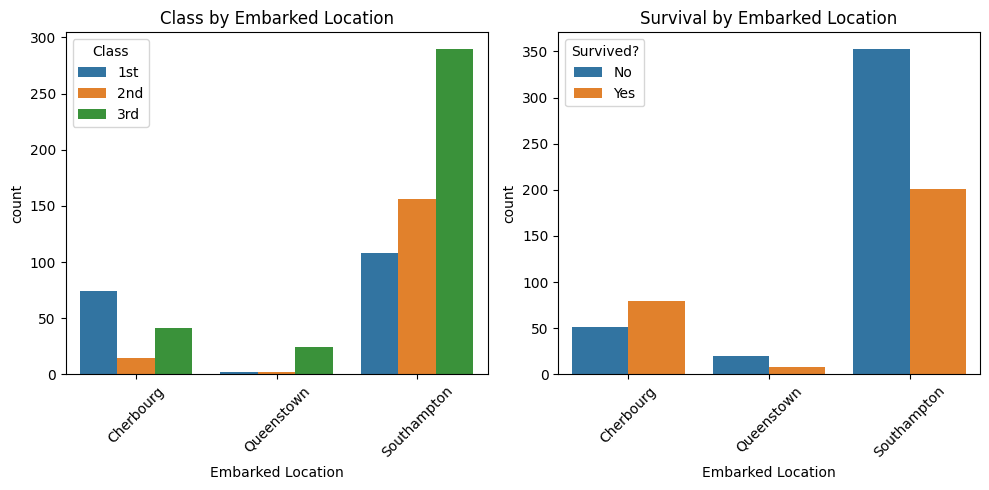

In [277]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(10, 5))

ax0.set_title('Class by Embarked Location')
sns.countplot(ax=ax0, data=df_titanic, x="Embarked", hue="Pclass")
ax0.set_xticklabels(embarked_labels, rotation=45)
ax0.set_xlabel('Embarked Location')
ax0.legend(class_labels, title='Class')

ax1.set_title('Survival by Embarked Location')
sns.countplot(ax=ax1, data=df_titanic, x="Embarked", hue="Survived")
ax1.set_xticklabels(embarked_labels, rotation=45)
ax1.set_xlabel('Embarked Location')
ax1.legend(survived_labels, title='Survived?')

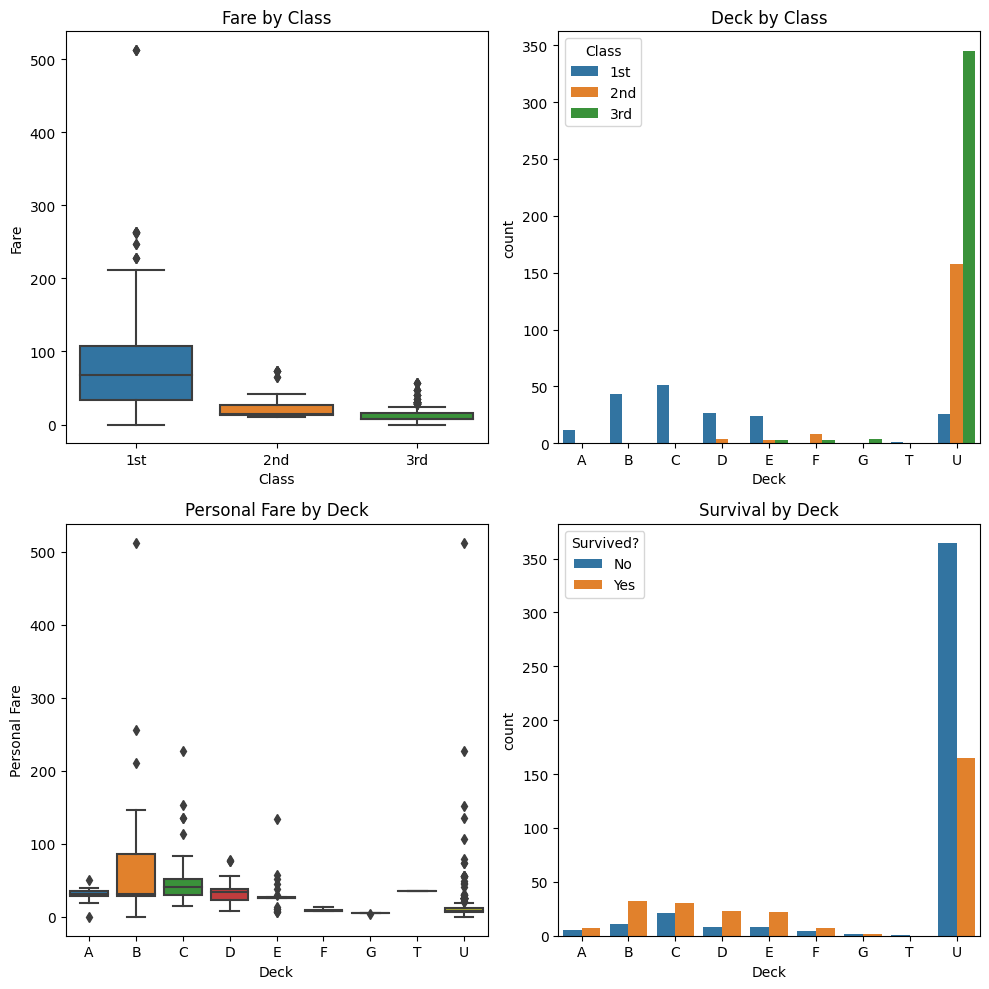

In [278]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax0.set_title('Fare by Class')
sns.boxplot(ax=ax0, data=df_titanic, x="Pclass", y="Fare")
ax0.set_xticklabels(class_labels)
ax0.set_xlabel('Class')
ax0.set_ylabel('Fare')

ax1.set_title('Deck by Class')
sns.countplot(ax=ax1, data=df_titanic, x="Deck", hue="Pclass", order=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels(deck_labels)
ax1.set_xlabel('Deck')
ax1.legend(class_labels, title='Class')

ax2.set_title('Personal Fare by Deck')
sns.boxplot(ax=ax2, data=df_titanic, x="Deck", y="Fare_Per_Person", order=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ax2.set_xticklabels(deck_labels)
ax2.set_xlabel('Deck')
ax2.set_ylabel('Personal Fare')

ax3.set_title('Survival by Deck')
sns.countplot(ax=ax3, data=df_titanic, x="Deck", hue="Survived", order=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ax3.set_xticklabels(deck_labels)
ax3.set_xlabel('Deck')
ax3.legend(survived_labels, title='Survived?')

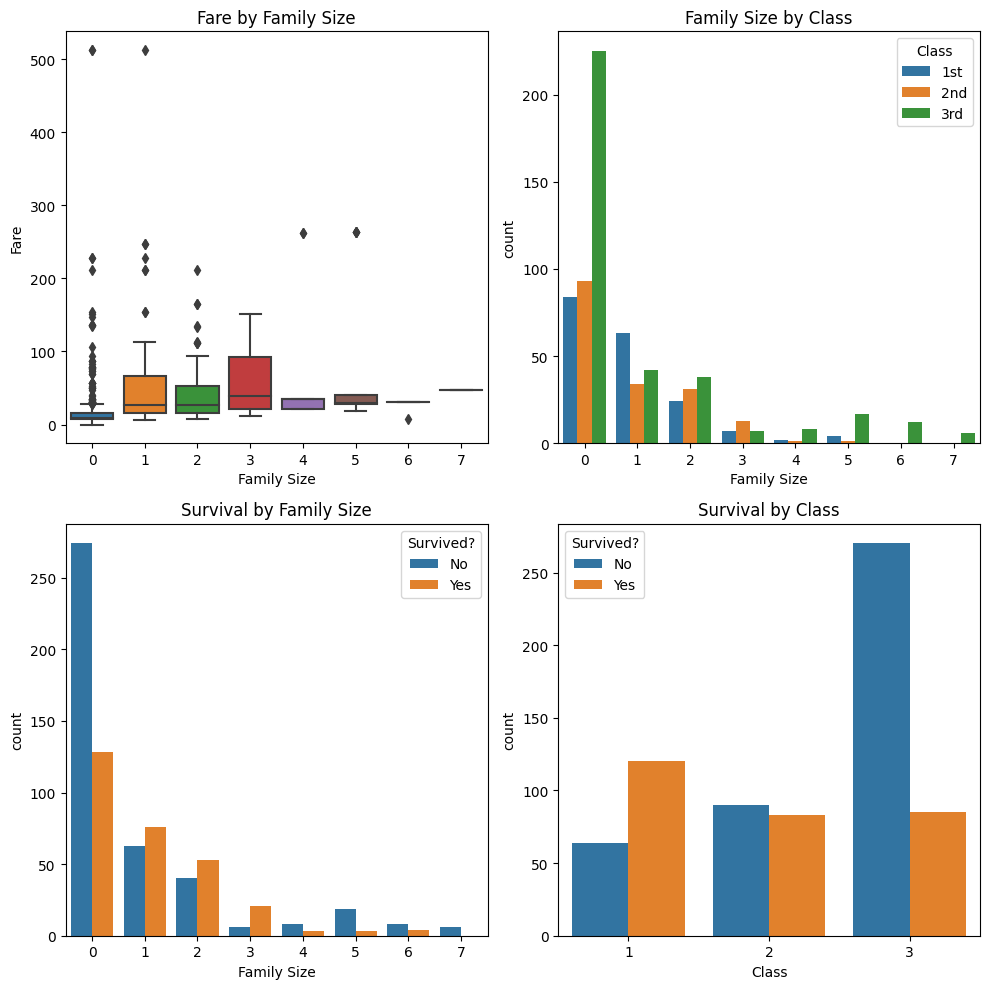

In [279]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax0.set_title('Fare by Family Size')
sns.boxplot(ax=ax0, data=df_titanic, x="Family_Size", y="Fare")
ax0.set_xlabel('Family Size')
ax0.set_ylabel('Fare')

ax1.set_title('Family Size by Class')
sns.countplot(ax=ax1, data=df_titanic, x="Family_Size", hue="Pclass")
ax1.set_xlabel('Family Size')
ax1.legend(class_labels, title='Class')

ax2.set_title('Survival by Family Size')
sns.countplot(ax=ax2, data=df_titanic, x="Family_Size", hue="Survived")
ax2.set_xlabel('Family Size')
ax2.legend(survived_labels, title='Survived?')

ax3.set_title('Survival by Class')
sns.countplot(ax=ax3, data=df_titanic, x="Pclass", hue="Survived")
ax3.set_xlabel('Class')
ax3.legend(survived_labels, title='Survived?')


## Dataset Splitting

In [280]:
X_train = df_titanic.drop('Survived',axis=1)
y_train = df_titanic.Survived

df_titanic_test = pd.read_csv('titanic/test.csv')
df_titanic_test_labels = pd.read_csv('titanic/gender_submission.csv')
df_titanic_test = df_titanic_test.merge(df_titanic_test_labels, on='PassengerId')

df_titanic_test = df_titanic_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
df_titanic_test = df_titanic_test[(df_titanic_test['Age'].notna())  & (df_titanic_test['Fare'].notna()) & (df_titanic_test['Embarked'].notna())]   
df_titanic_test['Sex'].replace(['male', 'female'], [1, 0], inplace=True)
df_titanic_test['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)
df_titanic_test = df_titanic_test.reset_index(drop=True)
df_titanic_test['Deck'] = df_titanic_test['Cabin'].map(lambda x: x[0] if x is not np.nan else 'U')
df_titanic_test['Deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)
df_titanic_test['Age_Group'] = df_titanic_test['Age'].map(lambda x: 0 if x < 18 else 1)
df_titanic_test = df_titanic_test.drop(['Cabin'], axis=1)
df_titanic_test['Family_Size']=df_titanic_test['SibSp'] + df_titanic_test['Parch']
df_titanic_test['Fare_Per_Person']=df_titanic_test['Fare'] / (df_titanic_test['Family_Size'] + 1)

X_test = df_titanic_test.drop('Survived',axis=1)
y_test = df_titanic_test.Survived

## Logistic Regression

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


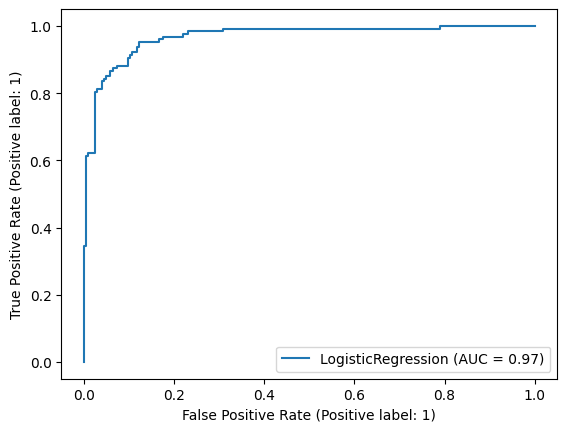

In [293]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
lr_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

In [294]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['predicted no','Predicted yes'], index=['Actual no', 'Actual yes'])

,predicted no,Predicted yes
Actual no,182,22
Actual yes,10,117


In [295]:
model.score(X_test, y_test)

0.9033232628398792

In [296]:
prediction = model.predict(X_test)
np.sum(prediction == y_test )/ len(y_test)

0.9033232628398792

## Nearest Neighbours

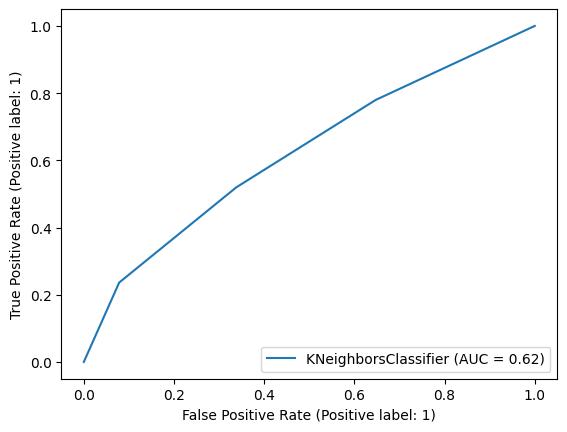

In [297]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
knn_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

## Naive Bayes

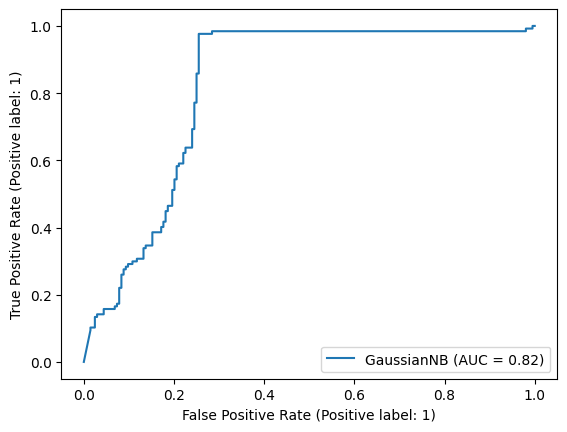

In [298]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
nb_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

## Support Vector Machine

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


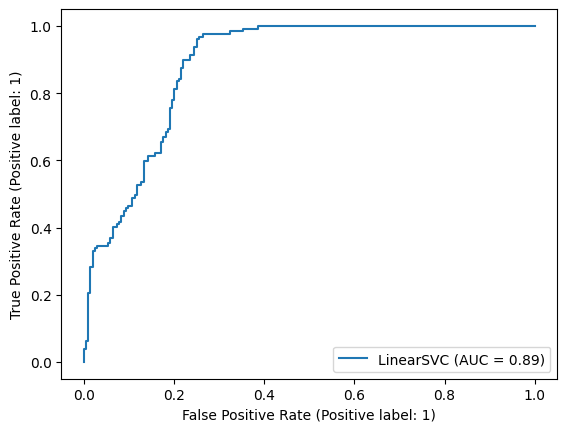

In [299]:
model = LinearSVC()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

## Neural Network

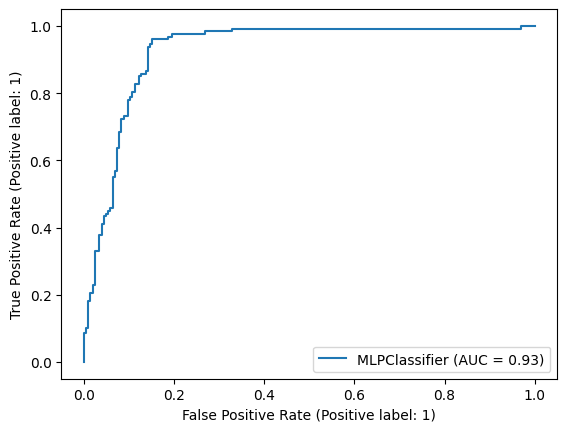

In [300]:
model = MLPClassifier()
model.fit(X_train,y_train)  
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
mlp_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

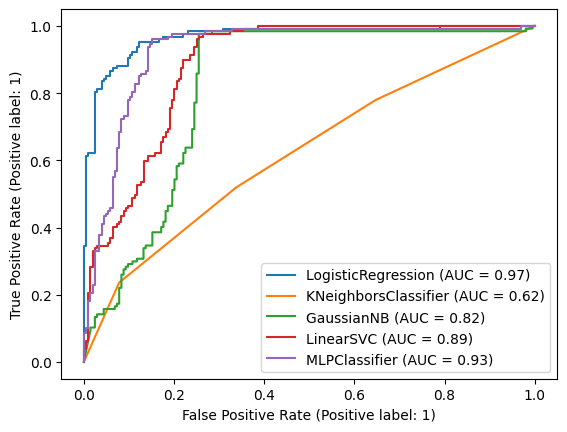

In [301]:
plt.figure()
ax = plt.gca()
lr_disp.plot(ax=ax)
knn_disp.plot(ax=ax)
nb_disp.plot(ax=ax)
svc_disp.plot(ax=ax)
mlp_disp.plot(ax=ax)
plt.show()